In [9]:
import numpy as np
import pandas as pd 
from numpy import linalg as la
from scipy.stats import norm
from scipy import optimize
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

import tiboT_test as tibot
import estimation
import LinearModels as lm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1000, 1) (1000,)


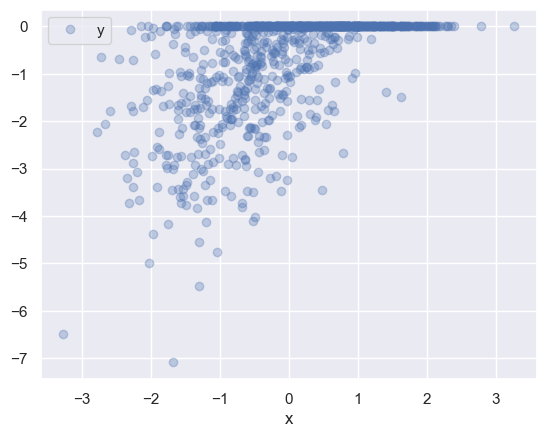

In [59]:
# Load data
data = pd.read_csv('adv micro data.csv')
y = data['y'].values
x = data[['x']].values
print(x.shape, y.shape)

fig,ax = plt.subplots();
ax.plot(x, y, 'o', alpha=0.3, label='y');
ax.set_xlabel('x');
ax.legend();
plt.show()

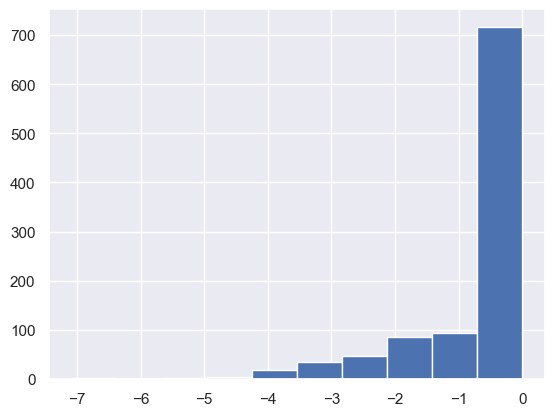

In [60]:
plt.hist(y) ;
#plt.hist(x)

In [61]:
#Add constant
x = np.c_[np.ones(x.shape[0]), x]

In [62]:
theta0 = tibot.starting_values(y,x)
print(theta0)

[-0.60068275  0.57252733  0.87964049]


In [63]:
result = estimation.estimate(tibot.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 1.006679
         Iterations: 12
         Function evaluations: 52
         Gradient evaluations: 13


In [64]:
res1 = estimation.estimate(tibot.q, theta0, y, x)
result_dict1 = {'Starting values': theta0, 
              'Estimated values': res1['theta'], 
              'se': res1['se'],
              't': res1['t']}
lab_theta = ['mu', 'beta', 'sigma']

pd.DataFrame(result_dict1, index=lab_theta).round(3)

Optimization terminated successfully.
         Current function value: 1.006679
         Iterations: 12
         Function evaluations: 52
         Gradient evaluations: 13


,Starting values,Estimated values,se,t
mu,-0.601,0.543,0.081,6.673
beta,0.573,1.437,0.074,19.431
sigma,0.880,1.536,0.056,27.345


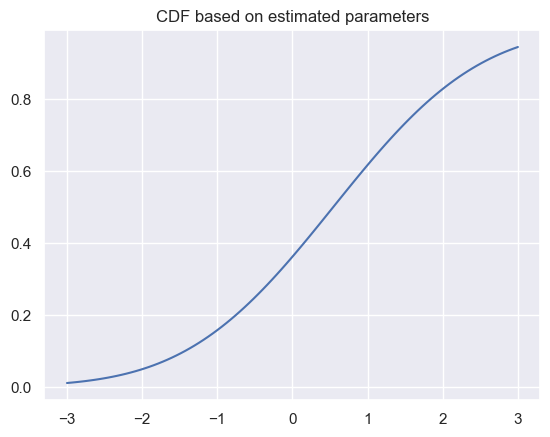

In [65]:
#Draw cdf based on estimated parameters
mu = res1['theta'][0]
sigma = res1['theta'][2]
y_latent = np.linspace(-3,3,100)
cdf = norm.cdf(y_latent, mu, sigma)
plt.plot(y_latent, cdf)
plt.title('CDF based on estimated parameters')
plt.show()

# Partial effects 


#### PE on censoring

In [66]:
beta = res1['theta'][1]

PE_censoring=(beta/sigma)*norm.pdf((x[:,1]*beta+mu)/sigma)
APE_censoring=PE_censoring.mean()
print(APE_censoring)

0.26118863628820227


In [71]:
# Parameters and data
N = len(x)  # Number of observations

# Calculate APE
phi_vals = norm.pdf((beta * x[:,1] + mu) / sigma)
APE = (1 / N) * np.sum(phi_vals * (beta / sigma))

# Gradients
dAPE_dbeta = (1 / N) * np.sum(
    norm.pdf((beta * x + mu) / sigma) * (1 / sigma) +
    norm.pdf((beta * x + mu) / sigma) * ((-1) * (beta * x + mu) / sigma**2) * x
)

dAPE_dmu = (1 / N) * np.sum(
    norm.pdf((beta * x + mu) / sigma) * (1 / sigma)
)

dAPE_dsigma = (1 / N) * np.sum(
    - norm.pdf((beta * x + mu) / sigma) * beta
)

# Jacobian vector
grad_ape = np.array([dAPE_dbeta, dAPE_dmu, dAPE_dsigma])

# Variance-covariance matrix (example)
# Replace with the actual variance-covariance matrix from your model estimation
cov_matrix = res1['cov']

# Variance of APE
var_ape = np.dot(np.dot(grad_ape.T, cov_matrix), grad_ape)

# Standard Error
SE_APE = np.sqrt(var_ape)
print("APE:", APE)
print("SE of APE:", SE_APE)

APE: 0.26118863628820227
SE of APE: 0.03384651574895971


### PE on conditional mean

In [ ]:
E=